## __Training ViT from scratch on GTSRB Dataset__

In [19]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

from torchvision import transforms
from torchvision.datasets import GTSRB
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.optim.lr_scheduler import LambdaLR

In [16]:
# Standard GTSRB normalization constants
MEAN = (0.3337, 0.3064, 0.3171)
STD = (0.2672, 0.2564, 0.2629)

IMAGE_SIZE = 32
NUM_CHANNELS = 3
NUM_CLASSES = 43

PATCH_SIZE = 4
HIDDEN_SIZE = 384
TRANSFORMER_BLOCKS = 10
ATTENTION_HEADS = 8
MLP_DIMENSION = 4 * HIDDEN_SIZE
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

WARMUP_PCT = 0.1
EPOCHS = 80
BATCH_SIZE = 512
LEARNING_RATE = 6e-4
WEIGHT_DECAY = 0.05
DROPOUT = 0.15
LABEL_SMOOTHING = 0.1

In [17]:
MEAN = (0.3337, 0.3064, 0.3171)
STD = (0.2672, 0.2564, 0.2629)

def apply_clahe(img):
    img_np = np.array(img)
    lab = cv2.cvtColor(img_np, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final_img = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final_img

train_transformation = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Lambda(lambda x: apply_clahe(x)),
    transforms.ToPILImage(),
    transforms.RandomRotation(15),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

test_transformation = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Lambda(lambda x: apply_clahe(x)),
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = GTSRB(root='./data', split='train', download=True, transform=train_transformation)
test_dataset = GTSRB(root='./data', split='test', download=True, transform=test_transformation)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 187M/187M [00:16<00:00, 11.2MB/s] 
100%|██████████| 89.0M/89.0M [00:10<00:00, 8.45MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 120kB/s] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12443864..1.8525741].


Sample batch shape: torch.Size([512, 3, 32, 32])
Batch means: tensor([0.2169, 0.2469, 0.2560]), Batch stds: tensor([1.0683, 1.0767, 1.0900])
Total number of samples in train dataset: 26640
Total number of samples in test dataset: 12630
Total number of classes: 43


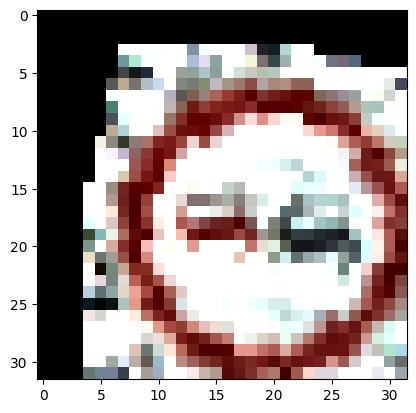

In [20]:
## checking the dataloader

dataiter = iter(train_loader)
images, labels = dataiter._next_data()
print(f'Sample batch shape: {images.shape}')
print(f'Batch means: {images.mean(dim=[0,2,3])}, Batch stds: {images.std(dim=[0,2,3])}')
print(f'Total number of samples in train dataset: {len(train_dataset)}')
print(f'Total number of samples in test dataset: {len(test_dataset)}')
print(f'Total number of classes: 43')

# sample image
img = images[10]
img = img / 2 + 0.5
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [21]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = nn.Conv2d(NUM_CHANNELS, HIDDEN_SIZE, kernel_size=PATCH_SIZE, stride=PATCH_SIZE)

    def forward(self, x):
        x = self.patch_embed(x)  # (B, HIDDEN_SIZE, N_patches_sqrt, N_patches_sqrt)
        x = x.flatten(2)         # (B, HIDDEN_SIZE, N_patches)
        x = x.transpose(1, 2)    # (B, N_patches, HIDDEN_SIZE)
        return x
    
example_patch_embedding = PatchEmbedding()
data_batch = iter(train_loader)._next_data()[0]

patches = example_patch_embedding(data_batch)
print(f'Patch embedding output shape: {patches.shape}')  # (BATCH_SIZE, N_patches, HIDDEN_SIZE)

Patch embedding output shape: torch.Size([512, 64, 384])


In [22]:
class TransformerEncoder(nn.Module):
    def __init__(self, dropout=DROPOUT):
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(HIDDEN_SIZE)
        self.layer_norm2 = nn.LayerNorm(HIDDEN_SIZE)
        self.multihead_attention = nn.MultiheadAttention(
            embed_dim=HIDDEN_SIZE, 
            num_heads=ATTENTION_HEADS, 
            batch_first=True,
            dropout=dropout  # Add attention dropout
        )
        self.mlp = nn.Sequential(
            nn.Linear(HIDDEN_SIZE, MLP_DIMENSION),
            nn.GELU(),
            nn.Dropout(dropout),  # Add dropout after GELU
            nn.Linear(MLP_DIMENSION, HIDDEN_SIZE),
            nn.Dropout(dropout)   # Add dropout after projection
        )

    def forward(self, x):
        x_norm = self.layer_norm1(x)
        attention_output, _ = self.multihead_attention(x_norm, x_norm, x_norm)
        x = x + attention_output
        x_norm = self.layer_norm2(x)
        mlp_output = self.mlp(x_norm)
        x = x + mlp_output
        return x
    

example_transformer_encoder = TransformerEncoder()
encoder_output = example_transformer_encoder(patches)
print(f'Transformer Encoder output shape: {encoder_output.shape}')  # (BATCH_SIZE, N_patches, HIDDEN_SIZE)

Transformer Encoder output shape: torch.Size([512, 64, 384])


In [23]:
class MLPHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_norm = nn.LayerNorm(HIDDEN_SIZE)
        self.fc = nn.Linear(HIDDEN_SIZE, NUM_CLASSES)

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.fc(x)
        return x
    
example_mlp_head = MLPHead()
mlp_output = example_mlp_head(encoder_output[:, 0, :])  # (BATCH_SIZE, NUM_CLASSES)
print(f'MLP Head output shape: {mlp_output.shape}')  # (BATCH_SIZE, NUM_CLASSES)

MLP Head output shape: torch.Size([512, 43])


In [24]:
class VisionTransformer(nn.Module):
    def __init__(self, dropout=0.1):
        super().__init__()
        self.patch_embedding = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1, 1, HIDDEN_SIZE))
        self.position_embeddings = nn.Parameter(torch.randn(1, NUM_PATCHES + 1, HIDDEN_SIZE))
        self.dropout = nn.Dropout(dropout)  # Add embedding dropout
        self.transformer_blocks = nn.Sequential(*[TransformerEncoder(dropout) for _ in range(TRANSFORMER_BLOCKS)])
        self.mlp_head = MLPHead()

    def forward(self, x):
        x = self.patch_embedding(x)
        batch_size = x.size(0)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.position_embeddings
        x = self.dropout(x)
        x = self.transformer_blocks(x)
        x = self.mlp_head(x[:, 0, :])
        return x

In [25]:
## training loop

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer().to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY
)

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

total_steps = len(train_loader) * EPOCHS
warmup_steps = max(1, int(WARMUP_PCT * total_steps))

In [26]:
def lr_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = LambdaLR(optimizer, lr_lambda)

In [27]:
global_step = 0
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_correct = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()
        global_step += 1

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        total_correct += correct

    avg_loss = total_loss / len(train_loader.dataset)
    accuracy = total_correct / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{EPOCHS}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

    model.eval()
    with torch.no_grad():
        total_correct = 0
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            total_correct += correct

        accuracy = total_correct / len(test_loader.dataset)
        print(f'Total correct predictions on test set: {total_correct} out of {len(test_loader.dataset)}')
        print(f'Test Accuracy: {accuracy:.4f}')

Epoch [1/80], Loss: 0.0071, Accuracy: 0.0801
Total correct predictions on test set: 1479 out of 12630
Test Accuracy: 0.1171
Epoch [2/80], Loss: 0.0064, Accuracy: 0.1487
Total correct predictions on test set: 2123 out of 12630
Test Accuracy: 0.1681
Epoch [3/80], Loss: 0.0051, Accuracy: 0.3209
Total correct predictions on test set: 6219 out of 12630
Test Accuracy: 0.4924
Epoch [4/80], Loss: 0.0039, Accuracy: 0.5215
Total correct predictions on test set: 6993 out of 12630
Test Accuracy: 0.5537
Epoch [5/80], Loss: 0.0032, Accuracy: 0.6693
Total correct predictions on test set: 9039 out of 12630
Test Accuracy: 0.7157
Epoch [6/80], Loss: 0.0026, Accuracy: 0.7855
Total correct predictions on test set: 10165 out of 12630
Test Accuracy: 0.8048
Epoch [7/80], Loss: 0.0022, Accuracy: 0.8553
Total correct predictions on test set: 10940 out of 12630
Test Accuracy: 0.8662
Epoch [8/80], Loss: 0.0021, Accuracy: 0.8895
Total correct predictions on test set: 11333 out of 12630
Test Accuracy: 0.8973
Epoch

In [28]:
torch.save(model.state_dict(), 'vit_gtsrb_clahe.pth')

In [29]:
saved_model = VisionTransformer().to(device)
saved_model.load_state_dict(torch.load('vit_gtsrb_clahe.pth'))

<All keys matched successfully>